# A/B Testing Ad Performance

Data source: [Kaggle](https://www.kaggle.com/faviovaz/marketing-ab-testing).

Data description:<br/>
This dataset contains information about ad exposure. The majority of the people are exposed to ads (the experimental group). And a small portion of people (the control group) instead saw a Public Service Announcement (PSA) (or nothing) in the exact size and place the ad would normally be.

#### Project description:
We want to know if the ads have an imapct on the conversion rate, and if they do, whether it is a positive impact.

#### Content
1. Importing required libraries
2. Loading & cleaning the data
3. Two-sided A/B Testing
	1. Formulating the hypothesis
	2. Solution1: Normal Approximation Method
		1. Building z test function
		2. Alternative solution: using statsmodels
	3. Solution 2: Chi-Squared Test
		1. Creating a two-way contingency table
		2. Building chi-squared test function
		3. Alternative solution: using scipy
	4. Solution3: Randomization Test (Resampling)
	5. Two-sided Hypothesis Testing Conclusion
4. One-sided Hypothesis Testing
	1. Hypothesis test using approximation method
	2. Hypothesis test using chi-squared test
	3. Hypothesis test using resampling
	4. One-sided Hypothesis Testing Conclusion
5. Practical significance

### 1. Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from numpy.random import default_rng
from statsmodels.stats.proportion import proportions_ztest
import pingouin as pg  # pandas statistical library -> (cohen's d)

# import itertools

import gc # to garbage collect
import warnings
warnings.filterwarnings("ignore")

# check the venv we are using
import sys
print(sys.executable)

c:\Users\mahno\Dropbox\CBO\.venv\Scripts\python.exe


In [2]:
# visualiztion settings
plt.style.use('ggplot')
sns.set_context('notebook')

### 2. Loading & cleaning the data

In [3]:
# loading the data
file = r'C:\Users\mahno\_projects_data\marketing_AB.csv'
df = pd.read_csv(file).drop(columns=['Unnamed: 0'])
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [4]:
# renaming the columns
df.columns = ['user_id', 'test_group', 'converted', 'total_ads', 'most_ads_day', 'most_ads_hour']

In [5]:
# function summarizing df descreptives
def check_df(df):
    
    df_info = pd.DataFrame(columns=['column', 'dtype', 'count', 'nulls', 'min', 'max', 'unique_values', 'smaple_value'])
    for col in df.columns:
        if df[col].dtype != object:
            df_info = df_info.append({'column':col, 'dtype':df[col].dtype, 'count':df[col].count(), 'nulls':df[col].isna().sum(), 'min':df[col].min(), 'max':df[col].max(), 'unique_values': df[col].nunique(), 'smaple_value':df[col][0]}, ignore_index=True)
        else:
            df_info = df_info.append({'column':col, 'dtype':df[col].dtype, 'count':df[col].count(), 'nulls':df[col].isna().sum(), 'min':np.nan, 'max':np.nan, 'unique_values': df[col].nunique(), 'smaple_value':df[col][0]}, ignore_index=True)

    return df_info

In [6]:
check_df(df)

,column,dtype,count,nulls,min,max,unique_values,smaple_value
0,user_id,int64,588101,0,900000,1654483,588101,1069124
1,test_group,object,588101,0,NaN,NaN,2,ad
2,converted,bool,588101,0,False,True,2,False
3,total_ads,int64,588101,0,1,2065,807,130
4,most_ads_day,object,588101,0,NaN,NaN,7,Monday
5,most_ads_hour,int64,588101,0,0,23,24,20


In [7]:
# checking memory usage by each column in MB
df.memory_usage(deep=True).div(pow(1024, 2))

Index             0.000122
user_id           4.486855
test_group       33.112987
converted         0.560857
total_ads         4.486855
most_ads_day     35.953379
most_ads_hour     4.486855
dtype: float64

#### Changing column types

In [8]:
# converting 'converted' bool column to numeric
replacements = {True: 1, False:0}
df['converted'] = df.converted.replace(replacements)

In [9]:
# checking values for test_group column
df.test_group.value_counts()

ad     564577
psa     23524
Name: test_group, dtype: int64

In [10]:
# changing the test_group column to binary [1, 0] (have seen the ads or not)
replacements = {'ad': 1, 'psa':0}
df['test_group'] = df.test_group.replace(replacements)

In [11]:
# checking values for most_ads_day column
df.most_ads_day.value_counts()

Friday       92608
Monday       87073
Sunday       85391
Thursday     82982
Saturday     81660
Wednesday    80908
Tuesday      77479
Name: most_ads_day, dtype: int64

In [12]:
# changing the most_ads_day column to day numbers
week_days_dict = {'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday': 7}
df['most_ads_day'] = df.most_ads_day.replace(week_days_dict)

In [13]:
# downcasting numbers
df = df.apply(pd.to_numeric, downcast='unsigned')

In [14]:
# checking user_id for duplicates
df.user_id.duplicated().sum()

0

In [15]:
check_df(df)

,column,dtype,count,nulls,min,max,unique_values,smaple_value
0,user_id,uint32,588101,0,900000,1654483,588101,1069124
1,test_group,uint8,588101,0,0,1,2,1
2,converted,uint8,588101,0,0,1,2,0
3,total_ads,uint16,588101,0,1,2065,807,130
4,most_ads_day,uint8,588101,0,1,7,7,2
5,most_ads_hour,uint8,588101,0,0,23,24,20


In [16]:
# checking memory usage by each column in MB
df.memory_usage(deep=True).div(pow(1024, 2))

Index            0.000122
user_id          2.243427
test_group       0.560857
converted        0.560857
total_ads        1.121714
most_ads_day     0.560857
most_ads_hour    0.560857
dtype: float64

In [17]:
# there are no duplicated rows to drop
df.duplicated().sum()

0

In [18]:
gc.collect()

80

In [19]:
# reducing the conversion rate among test group to have better graphs in this notebook
size = 3650
rng = default_rng()
df.loc[rng.choice(df.loc[(df.test_group==1)&(df.converted==1), 'converted'].index, size=size), 'converted'] = 0

### 3. A/B Testing

#### Formulating the hypothesis

In this experiment, we would like to know if our ads have any effects on conversion rates. <br/>

This is a difference between two proportions problem and we can define the null and alternative hypothesis as below: <br/>
H0: there is no difference in conversion rate among those who are exposed to the ads and those who are not, in the timeframe of the study <br/>
H1: there is a difference in conversion rate among those who are exposed to the ads and those who are not, in the timeframe of the study

In short:

H0: 'test group conversion rate' = 'control group conversion rate' ==> (p_test - p_control = 0) <br/>
H1: 'test group conversion rate' <> 'control group conversion rate' ==> (p_test - p_control <> 0)

In [20]:
# Creating test and control groups
test = df.loc[df.test_group==1, 'converted']
control = df.loc[df.test_group==0, 'converted']

# sample size
n_test = len(test)
n_control = len(control)

# calculating conversion rates for test and control groups
p_test = test.value_counts(normalize=True)[1]
p_control = control.value_counts(normalize=True)[1]

# relative uplift 
relative_uplift = (p_test - p_control)/p_control

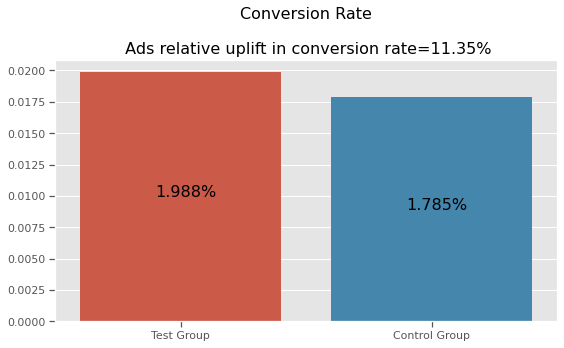

In [21]:
# plotting conversion rates
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot([0, 1], y=[p_test, p_control])
ax.set_xticklabels(['Test Group', 'Control Group'])

width_adj = 0.1
ax.annotate(f'{round(p_test*100, 3)}%', xy=[0-width_adj, p_test/2], fontsize=16)
ax.annotate(f'{round(p_control*100, 3)}%', xy=[1-width_adj, p_control/2], fontsize=16)

ax.set_title(f'Conversion Rate\n\n Ads relative uplift in conversion rate={round(relative_uplift*100, 2)}%', fontsize=16)
plt.tight_layout()

plt.show()

#### Solution1: Normal Approximation Method 

Checking assumptions:

In [22]:
# Creating a function to check normal approximation assumptions
def check_assumption(sample_size, proportion):
    if (sample_size*proportion>=10) & (sample_size*(1-proportion)>=10):
        return f'Normal approximation assumption is met'
    return f'Normal approximation assumption is NOT met'

In [23]:
# checking the assumption for test group
check_assumption(n_test, p_test)

'Normal approximation assumption is met'

In [24]:
# checking the assumption for control group
check_assumption(n_control, p_control)

'Normal approximation assumption is met'

Calculating z test statistic:

In [25]:
# Creating a function to calculate z test statistic
def get_z_statistic(n_test, p_test, n_control, p_control):

    # calculating conversion rate for the combined test and control groups
    p_both = (p_test*n_test + p_control*n_control)/(n_test+n_control)

    # calculating standard error of null hypothesis sampling distribution (p_test = p_control)
    standard_error = np.sqrt(p_both*(1-p_both)*(1/n_test + 1/n_control))

    # calculating z test statistic
    z_statistic = (p_test - p_control)/standard_error

    return z_statistic

In [26]:
z_statistic = get_z_statistic(n_test, p_test, n_control, p_control)
z_statistic

2.1857709161016636

Calculating p-value

In [27]:
# creating a function to calculate p-value from z test statistic
def get_p_value(z_statistic, tail='two-tail'):

    # Calculating p-value based on test type
    if tail == 'two-tail':
        p_value = (1 - stats.norm.cdf(abs(z_statistic)))*2
    if tail == 'left-tail':
        p_value = stats.norm.cdf(z_statistic)
    if tail == 'right-tail':
        p_value = 1 - stats.norm.cdf(z_statistic)

    return p_value    

In [28]:
# running a two-sided test 
p_value = get_p_value(z_statistic, tail='two-tail')
p_value

0.028832369589845364

Decision making and conclusion:

In [29]:
# checking the result against significance level of alpha=0.05
alpha = 0.05
p_value < alpha

True

The p_value is smaller than significance level so we reject the null hypothesis. <br/>
Conclusion: There is evidence that the conversion rate among those who are exposed to the ads differ from those who are not, in the timeframe of the study

##### Building z test function

We can create a function to do all the steps that we took above and also perform some visualization for us

In [30]:
# function for z test
def run_z_test(n_test, p_test, n_control, p_control, tail='two-tail', alpha=0.05, plot=False):
    
    # -----checking normal approximation assumptions-----
    
    # checking np>=10 and n(1-p)>=10
    test_assumption = (n_test*p_test>=10) & (n_test*(1-p_test)>=10)
    control_assumption = (n_control*p_control>=10) & (n_control*(1-p_control)>=10)

    if test_assumption & control_assumption:
        print('Normal approximation assumption is met/n/n')
    else:
        return f'Normal approximation assumption is NOT met'
        

    # -----Calculating z test statistic-----

    # calculating conversion rate for the combined test and control groups
    p_both = (p_test*n_test + p_control*n_control)/(n_test+n_control)

    # calculating standard error of null hypothesis sampling distribution (p_test = p_test)
    standard_error = np.sqrt(p_both*(1-p_both)*(1/n_test + 1/n_control))

    # calculating z test statistic
    z_statistic = (p_test - p_control)/standard_error
    print(f'z test statistic = {z_statistic}')

    # -----Calculating p-value-----
    
    # Calculating p-value based on test type
    if tail == 'two-tail':
        p_value = (1 - stats.norm.cdf(abs(z_statistic)))*2    
    elif tail == 'left-tail':
        p_value = stats.norm.cdf(z_statistic)
    elif tail == 'right-tail':
        p_value = 1 - stats.norm.cdf(z_statistic)
    else:
        return('Select tails from this list: [two-tail, left-tail, right-tail')

    print(f'p-value = {p_value}')

    # -----Checking p-value against significance level-----

    if p_value < alpha:
        print(f'(p-value: {p_value:.6f} < alpha: {alpha:.2f}) ==> Reject the null hypothesis.')
    else:
        print(f'(p-value: {p_value:.6f} >= alpha: {alpha:.2f}) ==> Fail to reject the null hypothesis.')
    

    # -----Visualization-----

    if plot:
        # calculating 1-alpha boundries for visualization
        if tail == 'two-tail':
            upper_bound = abs(z_statistic)
            lower_bound = -abs(z_statistic)
        elif tail == 'right-tail':
            upper_bound = z_statistic
            lower_bound = -10
        else:   # 'left-tail'
            upper_bound = 10
            lower_bound = z_statistic
        
        # plotting z distribution curve
        fig, ax = plt.subplots(figsize=(10, 6))
        x_z = np.linspace(-4, 4, 10000)
        y_z = stats.norm.pdf(x_z)
        sns.lineplot(x_z, y_z, color='steelblue')

        # highlighting the 1-alpha coverage
        ax.fill_between(x_z, y_z, where=((x_z>lower_bound)&(x_z<upper_bound)), color='steelblue', alpha=0.5)
        ax.fill_between(x_z, y_z, where=((x_z<lower_bound)|(x_z>upper_bound)), color='red', alpha=0.5)

        # plotting the mean of the distribution
        prob_max = stats.norm.pdf(x_z).max()
        ax.vlines(0, ymin=0, ymax=prob_max, linestyle=':', color='steelblue')

        # plotting the lower boundry
        if tail in ['two-tail', 'left-tail']:
            ymax_1 = stats.norm.pdf(lower_bound)
            ax.vlines(lower_bound, ymin=0, ymax=ymax_1, color='black', linestyle=':')
            ax.annotate(text=round(lower_bound, 2), xy=(lower_bound, ymax_1), bbox={'facecolor':'white'})

        # plotting the upper boundry
        if tail in ['two-tail', 'right-tail']:
            ymax_2 = stats.norm.pdf(upper_bound)
            ax.vlines(upper_bound, ymin=0, ymax=ymax_2, color='black', linestyle=':')
            ax.annotate(text=round(upper_bound, 2), xy=(upper_bound, ymax_2), bbox={'facecolor':'white'})

        ax.set_xlabel('z statistic')
        ax.set_ylabel('Density')
        ax.set_title('Normal approximation probability curve', fontsize=16)
        # plt.margins(x=0)
        plt.tight_layout()
        # plt.savefig('z_test_plot')
        plt.show()

    return z_statistic, p_value

Normal approximation assumption is met/n/n
z test statistic = 2.1857709161016636
p-value = 0.028832369589845364
(p-value: 0.028832 < alpha: 0.05) ==> Reject the null hypothesis.


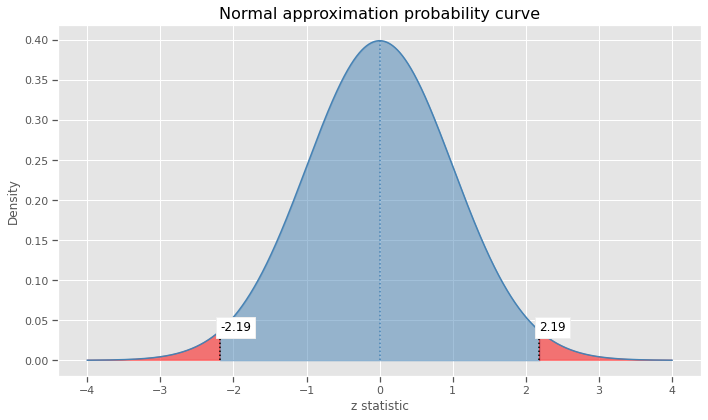

(2.1857709161016636, 0.028832369589845364)

In [31]:
# Running z test hypothesis testing
run_z_test(n_test, p_test, n_control, p_control, tail='two-tail', alpha=0.05, plot=True)

##### Alternative solution: using statsmodels
We can use statsmodels to simplify the steps we took to calculate z test statistic and p-value

In [32]:
# calculating z test statistic and p-value using statsmodels
z_statistic, p_value = proportions_ztest(count=[p_test*n_test, p_control*n_control], nobs=[n_test, n_control], alternative='two-sided')
print(f'p-value = {p_value}, z_statistic={z_statistic}')

#Checking p-value against significance level
alpha = 0.05

if p_value < alpha:
    print('(p-value: %.6f < alpha: %.2f) ==> Reject the null hypothesis.' %(p_value, alpha))
else:
    print('((p-value: %.6f >= alpha: %.2f)) ==> Fail to reject the null hypothesis.' %(p_value, alpha))

p-value = 0.02883236958984529, z_statistic=2.1857709161016636
(p-value: 0.028832 < alpha: 0.05) ==> Reject the null hypothesis.


It returns the same results as the z test function

### Solution 2: Chi-Squared Test

#### Creating a two-way contingency table

In [33]:
# creating the contingency table
contingency_table = df.groupby(['test_group', 'converted']).converted.count().unstack(level=-2).rename(index={0:'not-converted', 1:'converted'}, columns={0:'no ads', 1:'ads'})
contingency_table

test_group,no ads,ads
converted,,
not-converted,23104,553353
converted,420,11224


#### Building chi-squared test function

In [34]:
# creating a function to perform chi-sqaured hypothesis test
def run_chi_square_test(contingency_table, alpha=0.05, plot=False):

    # -----checking & calculating chi-squared approximation assumptions & value-----

    # adding test and control samples
    total_sample_size = contingency_table.sum(axis=1).sum()

    # creating a list to later add chi-squared elemnts to
    expected_cell_counts = []
    
    # looping through contingency_table to check assumptions and calculate chi-squared elemnts
    for row in contingency_table.index:
        row_total = contingency_table.loc[row, :].sum()
        for col in contingency_table.columns:
            column_total = contingency_table.loc[:, col].sum()
            expected_count = (row_total*column_total/total_sample_size)
            
            # checking chi-squared assumption of np>=5
            if expected_count<5:
                return 'Data does not meet chi-square approximation assumptions'
            chi_square_cell = (contingency_table.loc[row, col]-expected_count)**2 / expected_count
            expected_cell_counts.append(chi_square_cell)

    # calculating chi-squared test statistic
    chi_square_statistic = sum(expected_cell_counts)   

    # -----Calculating p-value-----    
    
    # Calculating p-value based on test type
    degree_of_freedom = (contingency_table.shape[0]-1)*(contingency_table.shape[1]-1)
    p_value = 1 - stats.chi2.cdf(chi_square_statistic, df=degree_of_freedom)
    print(f'chi-squared statistic = {chi_square_statistic}, degree of freedom = {degree_of_freedom}')  
    print(f'p-value = {p_value}') 

    if p_value < alpha:
        print(f'(p-value: {p_value:.6f} < alpha: {alpha:.2f}) ==> Reject the null hypothesis.')
    else:
        print(f'(p-value: {p_value:.6f} >= alpha: {alpha:.2f}) ==> Fail to reject the null hypothesis.')


    # -----Visualization-----

    if plot:
        
        # plotting chi-squared distribution curve
        fig, ax = plt.subplots(figsize=(10, 6))
        x_z = np.linspace(0, 5, 1000)
        y_z = stats.chi2.pdf(x_z, df=degree_of_freedom)
        sns.lineplot(x_z, y_z, color='steelblue')

        # highlighting the 1-alpha coverage
        ax.fill_between(x_z, y_z, where=(x_z<chi_square_statistic), color='steelblue', alpha=0.5)
        ax.fill_between(x_z, y_z, where=(x_z>chi_square_statistic), color='red', alpha=0.5)

        ax.axvline(x=chi_square_statistic, color='red', linestyle=':', lw=3)
        ax.annotate(f'chi-squared\nstatistic:\n{chi_square_statistic:.2f}', xy = (chi_square_statistic-0.6, 4), bbox={'facecolor':'white'})

        ax.set_xlabel('chi-squared statistic')
        ax.set_ylabel('Density')
        ax.set_title('chi-squared approximation probability curve', fontsize=16)
        plt.tight_layout()
        # plt.savefig('chi_square_test_plot')
        plt.show()

    return chi_square_statistic, p_value

chi-squared statistic = 4.777594497675905, degree of freedom = 1
p-value = 0.028832369589845364
(p-value: 0.028832 < alpha: 0.05) ==> Reject the null hypothesis.


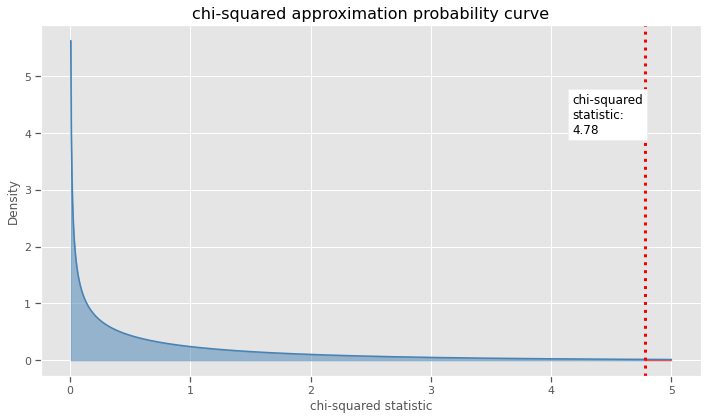

(4.777594497675905, 0.028832369589845364)

In [35]:
run_chi_square_test(contingency_table, alpha=0.05, plot=True)

#### Alternative solution: using scipy

In [36]:
chi_square_statistic, p_value, degree_of_freedom, expected_frequencies = stats.chi2_contingency(contingency_table, correction=False)
print(f'chi square statistic = {chi_square_statistic}, degree of freedom = {degree_of_freedom}')  
print(f'p-value = {p_value}') 

if p_value < alpha:
    print(f'(p-value: {p_value:.6f} < alpha: {alpha:.2f}) ==> Reject the null hypothesis.')
else:
    print(f'(p-value: {p_value:.6f}>= alpha: {alpha:.2f}) ==> Fail to reject the null hypothesis.')

chi square statistic = 4.777594497675905, degree of freedom = 1
p-value = 0.028832369589845416
(p-value: 0.028832 < alpha: 0.05) ==> Reject the null hypothesis.


The results are the same as the chi_square_test function and z_test function

### Solution3: Randomization Test (Resampling)

In [37]:
# creating a resampling function
def run_resampling_test(n_test, p_test, n_control, p_control, n_trials=5000, tail='two-tail', alpha=0.05, plot=False, bins=50):
    
    # -----Calculating z test statistic-----

    # calculating conversion rate for the combined test and control groups
    p_both = (p_test*n_test + p_control*n_control)/(n_test+n_control)

    # statistic to be tested
    statistic = p_test - p_control

    # creating sampling proportion distribution using bootstraping based on null hypothesis for the test and control groups
    rng = default_rng()
    test_samples_p = pd.Series([sum(rng.choice([1, 0], p=[p_both, 1-p_both], size=n_test, replace=True, shuffle=True))/n_test for i in np.arange(n_trials)])
    control_samples_p = pd.Series([sum(rng.choice([1, 0], p=[p_both, 1-p_both], size=n_control, replace=True, shuffle=True))/n_control for i in np.arange(n_trials)])

    # calculating difference between test ad control proportions to create the sampling distribution of the null hypothesis
    null_samples_p_diff = test_samples_p - control_samples_p
    # calculating mean and standard error for the sampling distribution of conversion rates differnces
    null_samples_p_diff_mean = null_samples_p_diff.mean()
    null_samples_p_diff_std = null_samples_p_diff.std()

    print(f'Randomized Distribution Mean : {null_samples_p_diff_mean}')
    print(f'Randomized Distribution Standard Error : {null_samples_p_diff_std}')


    # calculating z test statistic
    z_statistic = statistic/null_samples_p_diff_std
    print(f'z test statistic = {z_statistic}')


    # -----Calculating p-value-----
    
    # Calculating p-value based on test type
    if tail == 'two-tail':
        p_value = (1 - stats.norm.cdf(abs(z_statistic)))*2    
    elif tail == 'left-tail':
        p_value = stats.norm.cdf(z_statistic)
    elif tail == 'right-tail':
        p_value = 1 - stats.norm.cdf(z_statistic)
    else:
        return('Select tails from this list: [two-tail, left-tail, right-tail')

    print(f'p-value = {p_value}')


    # -----Checking p-value against significance level-----

    if p_value < alpha:
        print(f'(p-value: {p_value:.6f} < alpha: {alpha:.2f}) ==> Reject the null hypothesis.')
    else:
        print(f'(p-value: {p_value:.6f} >= alpha: {alpha:.2f}) ==> Fail to reject the null hypothesis.')
    

    # -----Visualization-----

    if plot:

        # -----probability plot for sample differnces-----
        
        # creating probability plot for normality check
        fig, ax = plt.subplots(figsize=(6, 5))
        stats.probplot(null_samples_p_diff, plot=ax)
        ax.set_title('Normality check for\nrandomized sampling distribution of\nconversion rates difference')


        # -----plotting a histogram for sample differnces-----

        # calculating p difference boundries for visualization
        if tail == 'two-tail':
            upper_bound = abs(statistic)
            lower_bound = -abs(statistic)
        elif tail == 'right-tail':
            upper_bound = statistic
            lower_bound = -10
        else:   # 'left-tail'
            upper_bound = 10
            lower_bound = statistic

        # plotting sample differnces histogram
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
        ax1 = sns.histplot(null_samples_p_diff, bins=bins, ax=ax1)
        
        # getting x coordinates for histogram bins for highlighting
        for i in ax1.patches:
            if  (i.get_x() >= upper_bound) or (i.get_x() <= lower_bound):
                i.set_color('red')
        ax1.axvline(statistic, color='red', linestyle=':', lw=3)
        ax1.annotate(text=f'{statistic:.4f}', xy=(statistic, 50), bbox={'facecolor':'white'})

        ax1.set_title(f'Bootstrapped sampling distribution of the conversion rate difference\nnumber of trials: {n_trials}', fontsize=16)
        ax1.set_ylabel('Frequency')


        # -----plotting a z distribution for z test statistic-----

        # calculating z test stztistic boundries for visualization
        if tail == 'two-tail':
            z_upper_bound = abs(z_statistic)
            z_lower_bound = -abs(z_statistic)
        elif tail == 'right-tail':
            z_upper_bound = z_statistic
            z_lower_bound = -10
        else:   # 'left-tail'
            z_upper_bound = 10
            z_lower_bound = z_statistic

        # plotting z distribution curve
        x_z = np.linspace(-4, 4, 10000)
        y_z = stats.norm.pdf(x_z)
        sns.lineplot(x_z, y_z, color='steelblue', ax=ax2)

        # highlighting the areas between and outside the z test statistic boundries
        ax2.fill_between(x_z, y_z, where=((x_z>z_lower_bound)&(x_z<z_upper_bound)), color='steelblue', alpha=0.5)
        ax2.fill_between(x_z, y_z, where=((x_z<z_lower_bound)|(x_z>z_upper_bound)), color='red', alpha=0.5)

        # plotting the mean of the distribution (generalized)
        prob_max = stats.norm.pdf(x_z).max()
        ax2.vlines(0, ymin=0, ymax=prob_max, linestyle=':', color='steelblue')

        # plotting the lower boundry
        if tail in ['two-tail', 'left-tail']:
            ymax_1 = stats.norm.pdf(z_lower_bound)
            ax2.vlines(z_lower_bound, ymin=0, ymax=ymax_1, color='black', linestyle=':')
            ax2.annotate(text=round(z_lower_bound, 2), xy=(z_lower_bound, ymax_1), bbox={'facecolor':'white'})

        # plotting the upper boundry
        if tail in ['two-tail', 'right-tail']:
            ymax_2 = stats.norm.pdf(z_upper_bound)
            ax2.vlines(z_upper_bound, ymin=0, ymax=ymax_2, color='black', linestyle=':')
            ax2.annotate(text=round(z_upper_bound, 2), xy=(z_upper_bound, ymax_2), bbox={'facecolor':'white'})

        ax2.set_xlabel('z test statistic')
        ax2.set_ylabel('Density')
        ax2.set_title('Normal approximation probability curve', fontsize=16)
        # plt.margins(x=0)
        plt.tight_layout()
        # plt.savefig('resampling_test_plot')
        plt.show()

    return z_statistic, p_value

Randomized Distribution Mean : 7.730763937686499e-06
Randomized Distribution Standard Error : 0.0009272750260742137
z test statistic = 2.1851814319294878
p-value = 0.028875546398675844
(p-value: 0.028876 < alpha: 0.05) ==> Reject the null hypothesis.


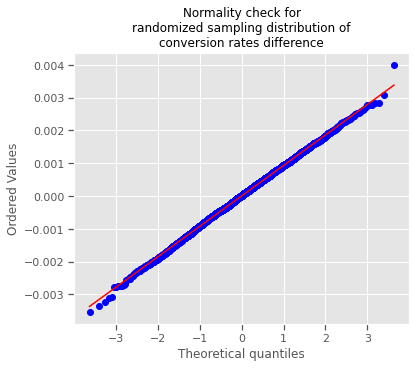

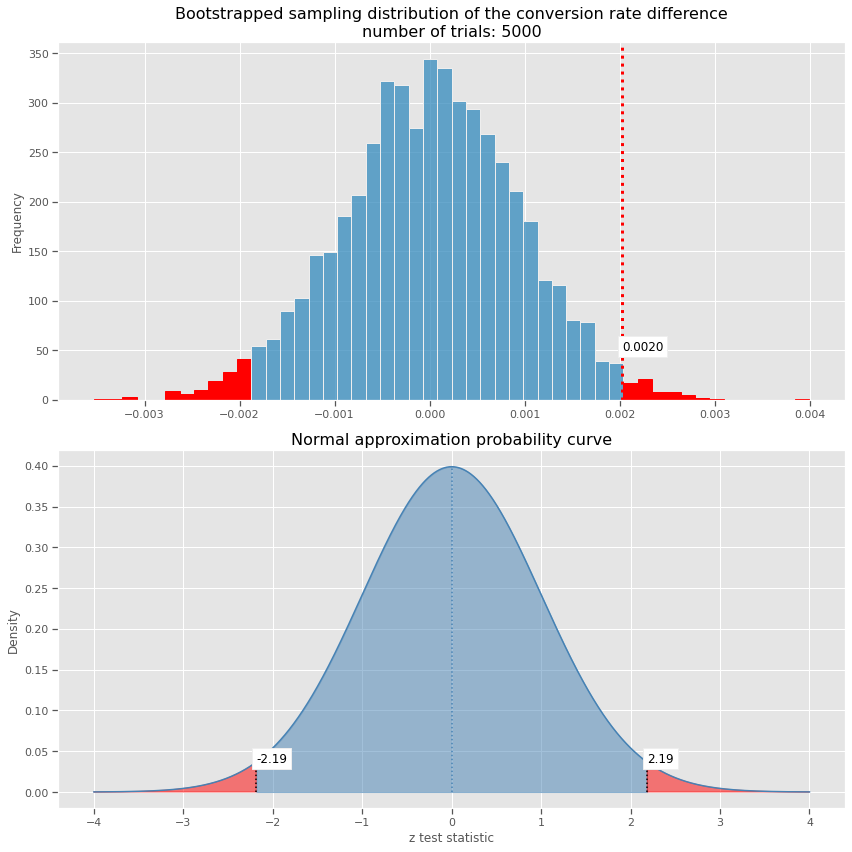

(2.1851814319294878, 0.028875546398675844)

In [38]:
run_resampling_test(n_test, p_test, n_control, p_control, n_trials=5000, tail='two-tail', alpha=0.05, plot=True)  

The results are quite close to the normal approximation method and the Chi-squared test

### Two-sided Hypothesis Testing Conclusion

We have performed 3 differnt hypothesis tests and all 3 lead to the same results.<br/>
The p_value is smaller than significance level so we reject the null hypothesis. <br/>
Therefore, we can conclude that there is evidence that the conversion rate among those who are exposed to the ads differ from those who are not, in the timeframe of the study

### 4. One-sided Hypothesis Testing

The above tests confirm a difference in coversion rate between those who are exposed to the ads and those who are not.<br/>
We can take the tests one step furthur and see if the ads are increasing the conversion rate.<br/>
For that, we can test for below hypothesis:

H0: 'test group conversion rate' = 'control group conversion rate' ==> (p_test - p_control = 0) <br/>
H1: 'test group conversion rate' > 'control group conversion rate' ==> (p_test - p_control > 0)

#### Hypothesis test using approximation method

Normal approximation assumption is met/n/n
z test statistic = 2.1857709161016636
p-value = 0.014416184794922682
(p-value: 0.014416 < alpha: 0.05) ==> Reject the null hypothesis.


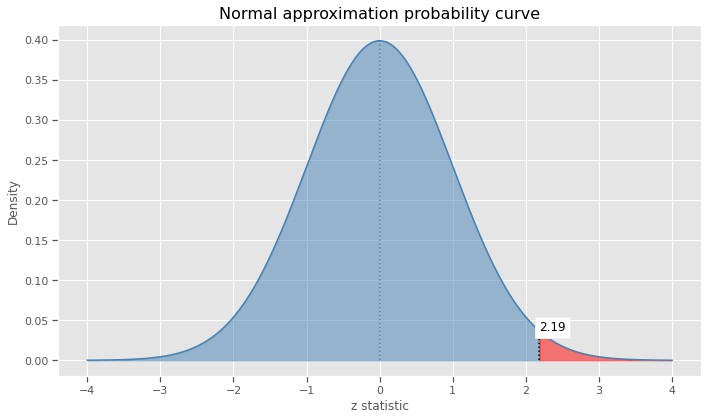

In [39]:
normal_approx_z_statistic, normal_approx_p_value = run_z_test(n_test, p_test, n_control, p_control, tail='right-tail', alpha=0.05, plot=True)

#### Hypothesis test using chi-squared test

In [40]:
# the below result is equivalent to a two-sided normal test
chi_square_statistic, chi_square_p_value = run_chi_square_test(contingency_table, alpha=0.05, plot=False)

chi-squared statistic = 4.777594497675905, degree of freedom = 1
p-value = 0.028832369589845364
(p-value: 0.028832 < alpha: 0.05) ==> Reject the null hypothesis.


Final chi-squared statistic = 0.9996735115504742
Final p-value = 0.014416184794922682
(p-value: 0.014416 < alpha: 0.05) ==> Reject the null hypothesis.


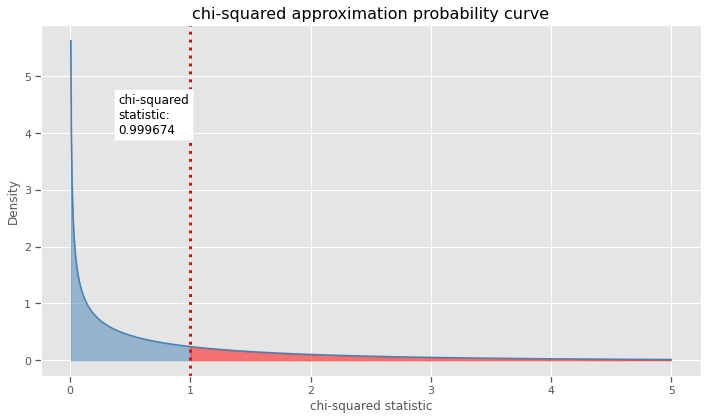

In [41]:
# So for one-side test, we divide the p_value by two and calculate the chi-squared statistic for that p-value
chi_square_p_value = chi_square_p_value/2
chi_square_statistic = 1- stats.chi2.ppf(chi_square_p_value, df=1)
print(f'Final chi-squared statistic = {chi_square_statistic}\nFinal p-value = {chi_square_p_value}')

if chi_square_p_value < alpha:
    print(f'(p-value: {chi_square_p_value:.6f} < alpha: {alpha:.2f}) ==> Reject the null hypothesis.')
else:
    print(f'(p-value: {chi_square_p_value:.6f} >= alpha: {alpha:.2f}) ==> Fail to reject the null hypothesis.')

# plotting chi-squared distribution curve
degree_of_freedom = 1
fig, ax = plt.subplots(figsize=(10, 6))
x_z = np.linspace(0, 5, 1000)
y_z = stats.chi2.pdf(x_z, df=degree_of_freedom)
sns.lineplot(x_z, y_z, color='steelblue')

# highlighting the 1-alpha coverage
ax.fill_between(x_z, y_z, where=(x_z<chi_square_statistic), color='steelblue', alpha=0.5)
ax.fill_between(x_z, y_z, where=(x_z>chi_square_statistic), color='red', alpha=0.5)

ax.axvline(x=chi_square_statistic, color='red', linestyle=':', lw=3)
ax.annotate(f'chi-squared\nstatistic:\n{chi_square_statistic:.6f}', xy = (chi_square_statistic-0.6, 4), bbox={'facecolor':'white'})

ax.set_xlabel('chi-squared statistic')
ax.set_ylabel('Density')
ax.set_title('chi-squared approximation probability curve', fontsize=16)
plt.tight_layout()
plt.savefig('chi_square_test_plot')
plt.show()

#### Hypothesis test using resampling

Randomized Distribution Mean : -1.4903243156409396e-06
Randomized Distribution Standard Error : 0.0009363531797636533
z test statistic = 2.1639956087731305
p-value = 0.015232343209687915
(p-value: 0.015232 < alpha: 0.05) ==> Reject the null hypothesis.


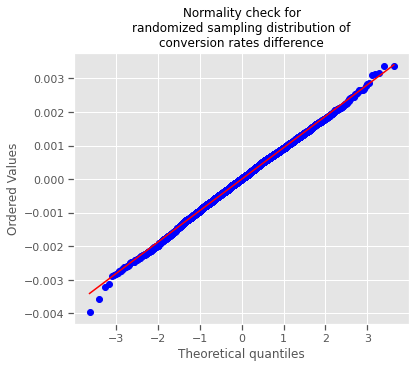

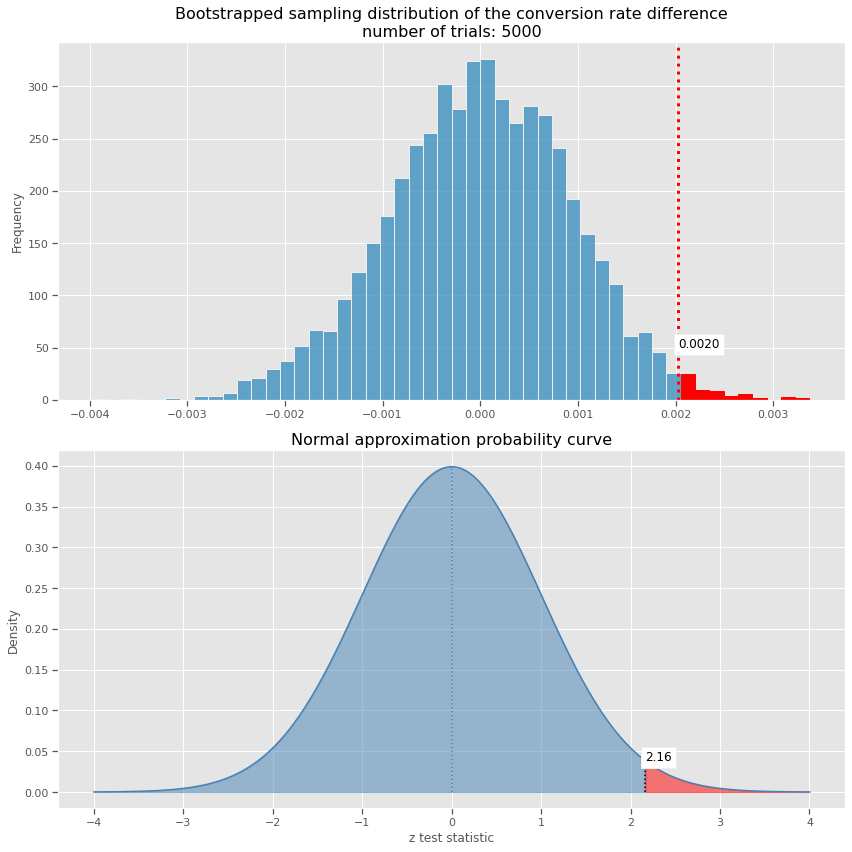

In [42]:
resampling_z_statistic, resampling_p_value = run_resampling_test(n_test, p_test, n_control, p_control, n_trials=5000, tail='right-tail', alpha=0.05, plot=True, bins=50)

#### One-sided Hypothesis Testing Conclusion

In [43]:
# index=['normal approximation', 'chi-squared', 'resampling']
resluts = pd.DataFrame(columns=['test_statistic', 'test_statistic_value', 'p_value', 'H1: p_test - p_control > 0'])
resluts.index.name = 'test_method'
resluts.loc['normal approximation', :] = ['z', normal_approx_z_statistic, normal_approx_p_value, normal_approx_p_value<alpha]
resluts.loc['chi-squared', :] = ['chi-squared', chi_square_statistic, chi_square_p_value, chi_square_p_value<alpha]
resluts.loc['resampling', :] = ['z', resampling_z_statistic, resampling_p_value, resampling_p_value<alpha]

print(f'\nSignificance level = {alpha}\n')
resluts


Significance level = 0.05



,test_statistic,test_statistic_value,p_value,H1: p_test - p_control > 0
test_method,,,,
normal approximation,z,2.185771,0.014416,True
chi-squared,chi-squared,0.999674,0.014416,True
resampling,z,2.163996,0.015232,True


Based on the results we can conclude that there is evidence that the conversion rate among those who are exposed to the ads are greater than those who are not, in the timeframe of the study.

### 5. Practical Significance
Now we need to check if the effect size of running the ads is reasonable.<br/>
Through hypothesis tests we proved that there is evidence for the ads impact on conversion rate. However, running ads is costly and there should be enough conversion rate boost that justifies the spend. The company can use its internal data to calculate the effect size required to justify the ads. Here we use Cohen's d to calculate the effect size.

In [44]:
# We can use pingouin library to calculate Cohen's d
pg.compute_effsize(test, control, eftype='cohen')

0.014545024303602286

Generally, any effect size below 0.2 is considered to be too little to justify the intervention. So the company may be better off saving their money on ad spend and do some research to see what other avenues they can explore to increase the conversion rate.